In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier
#from graphviz import Source   # Install it using: conda install -c conda-forge python-graphviz
from IPython.display import display, SVG

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns


In [24]:
# Įsikeliame duomenis.
liver_patient = pd.read_csv("duomenys/Indian_Liver_Patient.csv")
liver_patient.head()

#Pervadiname stulpelį dataset į liver_disease.
liver_patient.rename(columns={'Dataset': 'Liver_Disease'}, inplace=True)
# Persikoduojame stulpelį lytis (Female=0 and Male = 1).
liver_patient['Gender'] = liver_patient['Gender'].apply(lambda x: 1 if x =='Male' else 0)

# Užpildome praleistas reikšmes vidurkiu .
liver_patient['Albumin_and_Globulin_Ratio'].mean()
liver_patient=liver_patient.fillna(0.94)


In [25]:
liver_patient.shape # Duomenų lentelėje yra 583 stebėjimai ir 11 kintamųjų.

# Pasižiūrime, kiek kiekvienoje grupėje yra stebėjimų.
liver_patient.groupby('Liver_Disease').size()

# Gauname, kad sergančių yra 416, o nesergančių 167 asmenys(1 - not diseased;2- diseased).

Liver_Disease
1    416
2    167
dtype: int64

# RANDOM FOREST

The Random Forest Classifier yra sprendimų medžių rinkinys iš atsitiktinai parinkto mokymo rinkinio pogrupio. Jis sujungia balsus iš skirtingų sprendimų medžių, kad būtų galima nuspręsti galutinę bandomojo objekto klasę.

 PIRMAS MODELIS

In [26]:
#Apibrėžiame X ir y.
X = liver_patient[['Age', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase',
        'Alamine_Aminotransferase', 'Aspartate_Aminotransferase', 'Total_Protiens', 
        'Albumin', 'Albumin_and_Globulin_Ratio','Gender']]
y = liver_patient[['Liver_Disease']]


#Duomenų rinkinį padaliname į 70% of training set ir 30% test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(408, 10) (408, 1) (175, 10) (175, 1)


C:\Users\ligita\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


Random Forest Score:  100.0
Random Forest Test Score:  72.57
Accuracy:  0.7257142857142858

Classification report: 
               precision    recall  f1-score   support

           1       0.75      0.91      0.83       125
           2       0.54      0.26      0.35        50

    accuracy                           0.73       175
   macro avg       0.65      0.59      0.59       175
weighted avg       0.69      0.73      0.69       175

Confusion Matrix:
      0   1
0  114  11
1   37  13


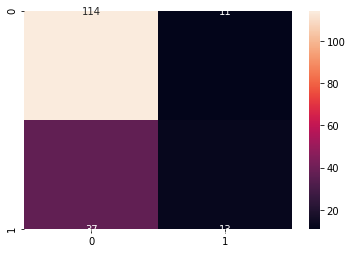

In [40]:
#Modelio kūrimas.
rf = RandomForestClassifier(n_estimators=100, random_state=150, class_weight = {1:1,2:2})
#n_estimators=100 (imame 100 medžių)
rf.fit(X_train, y_train)
rf_predicted = rf.predict(X_test)

random_forest_score      = round(rf.score(X_train, y_train) * 100, 2)
random_forest_score_test = round(rf.score(X_test, y_test) * 100, 2)


print('Random Forest Score: ', random_forest_score)
print('Random Forest Test Score: ', random_forest_score_test)
#Apskaičiuojame savo modelio tikslumą.
print('Accuracy: ', accuracy_score(y_test,rf_predicted))
print('\nClassification report: \n', classification_report(y_test,rf_predicted))
#Suskaičiuojame Confusion matricą.
cm=pd.DataFrame(confusion_matrix(y_test,rf_predicted))
print("Confusion Matrix:\n", cm)


g = sns.heatmap(confusion_matrix(y_test,rf_predicted), annot=True, fmt="d")

In [28]:
#Taigi galime daryti išvadą, kad mūsų modelis veikė 74.29% tikslumu.
#Confusion Matrix atskleidžia, kad modelis iš visų sergančių 119 klasifikuoja teisingai 
#(kaip sergančius) ir 6 kaip nesergančius.Iš visų nesergančių 39 asmenis klasifikuoja kaip
#sergančius,o 11 klasikuoja teisingai.

FEATURE IMPORTANCE 

In [29]:
# Atspausdiname kintamųjų reiškmingumo lentelę.
pd.DataFrame(rf.feature_importances_,
             index=liver_patient.drop('Liver_Disease', axis=1).columns)
# Iš gautos lentelės matome, kad reikšmingiausias kintamasis yra Direct_Bilirubin, 
# o mažiausiai reikšmingas yra Albumin_and_Globulin_Ratio.

,0
Age,0.138523
Gender,0.095895
Total_Bilirubin,0.082974
Direct_Bilirubin,0.145606
Alkaline_Phosphotase,0.119948
Alamine_Aminotransferase,0.141394
Aspartate_Aminotransferase,0.093562
Total_Protiens,0.097120
Albumin,0.075251
Albumin_and_Globulin_Ratio,0.009726


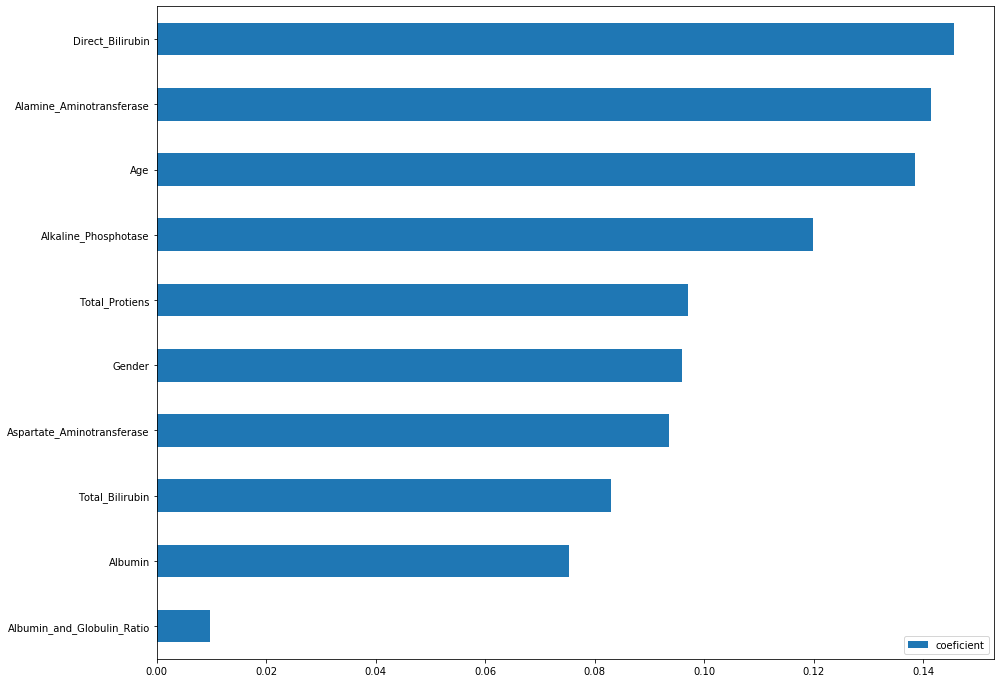

In [30]:
# Taip pat, nubraižome grafiką, kuris vizualiai atskleidžia, kurie kintamieji turi didžiausią
#reikšmingumą,ir kurie mažiausią.
variable_importance=pd.DataFrame(rf.feature_importances_,columns=['coeficient'],
             index=liver_patient.drop('Liver_Disease', axis=1).columns)
variable_importance.sort_values(by = ["coeficient"]).plot(kind='barh', figsize=(15,12))

 ANTRAS MODELIS  (Pridėjus naujus stulpelius)

In [31]:
#Apsiskaičiuojame Globuliną
liver_patient['Globulin'] = liver_patient['Albumin'] / liver_patient['Albumin_and_Globulin_Ratio']

#Susiskaičiuojam netiesioginį bilirubiną (nekonjuguotas) (jis lygus iš bendro atėmus tiesioginį)
liver_patient['Indirect_Bilirubin'] = liver_patient['Total_Bilirubin'] - liver_patient['Direct_Bilirubin']
liver_patient['Protiens_Ratio'] = liver_patient['Total_Protiens'] / liver_patient['Albumin']

liver_patient.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Liver_Disease,Globulin,Indirect_Bilirubin,Protiens_Ratio
0,65,0,0.7,0.1,187,16,18,6.8,3.3,0.90,1,3.666667,0.6,2.060606
1,62,1,10.9,5.5,699,64,100,7.5,3.2,0.74,1,4.324324,5.4,2.343750
2,62,1,7.3,4.1,490,60,68,7.0,3.3,0.89,1,3.707865,3.2,2.121212
3,58,1,1.0,0.4,182,14,20,6.8,3.4,1.00,1,3.400000,0.6,2.000000
4,72,1,3.9,2.0,195,27,59,7.3,2.4,0.40,1,6.000000,1.9,3.041667


In [32]:
X = liver_patient[['Age', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase',
        'Alamine_Aminotransferase', 'Aspartate_Aminotransferase', 'Total_Protiens', 
        'Albumin', 'Albumin_and_Globulin_Ratio','Gender','Globulin','Indirect_Bilirubin','Protiens_Ratio']]
y = liver_patient[['Liver_Disease']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(408, 13) (408, 1) (175, 13) (175, 1)


C:\Users\ligita\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Random Forest Score:  100.0
Random Forest Test Score:  70.86
Accuracy:  0.7085714285714285

Classification report: 
               precision    recall  f1-score   support

           1       0.75      0.90      0.81       125
           2       0.48      0.24      0.32        50

    accuracy                           0.71       175
   macro avg       0.61      0.57      0.57       175
weighted avg       0.67      0.71      0.67       175

Confusion Matrix:
      0   1
0  112  13
1   38  12


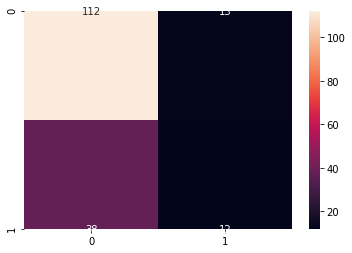

In [33]:

rf = RandomForestClassifier(n_estimators=100, random_state=150,class_weight = {1:1,2:3})
rf.fit(X_train, y_train)
rf_predicted = rf.predict(X_test)

random_forest_score      = round(rf.score(X_train, y_train) * 100, 2)
random_forest_score_test = round(rf.score(X_test, y_test) * 100, 2)


print('Random Forest Score: ', random_forest_score)
print('Random Forest Test Score: ', random_forest_score_test)
print('Accuracy: ', accuracy_score(y_test,rf_predicted))
print('\nClassification report: \n', classification_report(y_test,rf_predicted))
cm=pd.DataFrame(confusion_matrix(y_test,rf_predicted))
print("Confusion Matrix:\n", cm)


g = sns.heatmap(confusion_matrix(y_test,rf_predicted), annot=True, fmt="d")

In [39]:
#Pridėjus naujus stulpelius mūsų modelis veikė 70.86% tikslumu.
#Confusion Matrix atskleidžia, kad modelis iš visų sergančių 112 klasifikuoja teisingai 
#(kaip sergančius) ir 13 kaip nesergančius.Iš visų nesergančių 38 asmenis klasifikuoja kaip
#sergančius,o 12 klasikuoja teisingai.Galime teigti, jog pirmasis modelis veikia tiksliau.


FEATURE IMPORTANCE

In [35]:
pd.DataFrame(rf.feature_importances_,
             index=liver_patient.drop('Liver_Disease', axis=1).columns)
# Iš gautos lentelės matome, kad reikšmingiausiu kintamuoju išliko Direct_Bilirubin, 
# o mažiausiai reikšmingu Albumin_and_Globulin_Ratio.

,0
Age,0.097403
Gender,0.087679
Total_Bilirubin,0.068935
Direct_Bilirubin,0.128131
Alkaline_Phosphotase,0.084455
Alamine_Aminotransferase,0.112493
Aspartate_Aminotransferase,0.065962
Total_Protiens,0.053748
Albumin,0.052616
Albumin_and_Globulin_Ratio,0.011094


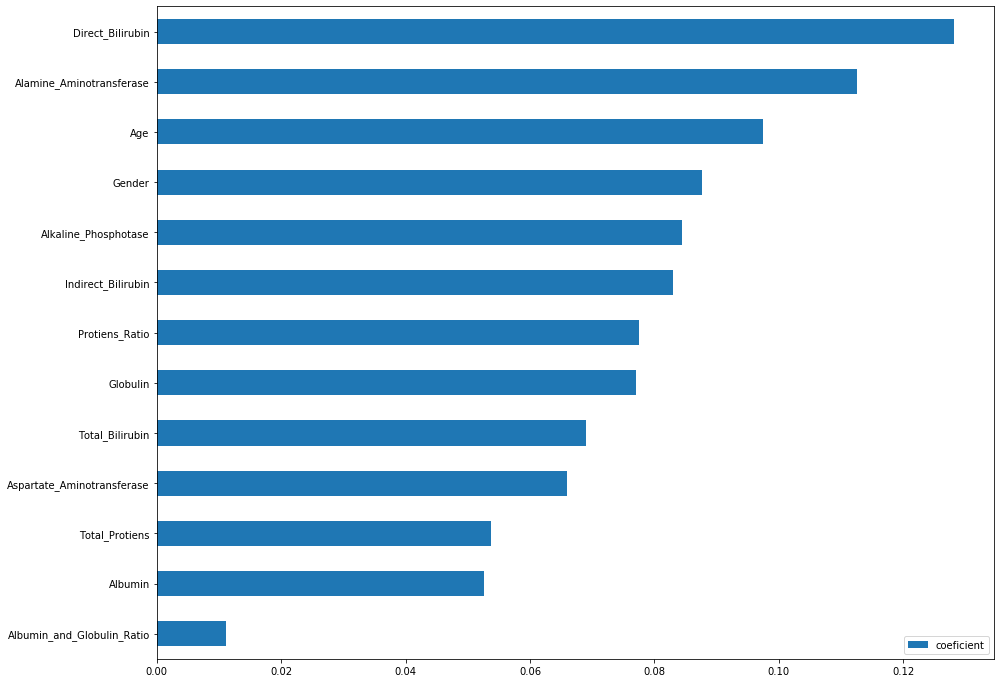

In [36]:
variable_importance=pd.DataFrame(rf.feature_importances_,columns=['coeficient'],
             index=liver_patient.drop('Liver_Disease', axis=1).columns)
variable_importance.sort_values(by = ["coeficient"]).plot(kind='barh', figsize=(15,12))

DECISION TREES 

In [37]:
from sklearn.tree import DecisionTreeClassifier
# Sukuriame decision tree objektą.
classifier = DecisionTreeClassifier()

# Train the model using the training sets and check score
classifier.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Decision tree Score:  100.0
Decision tree Test Score:  70.86
Accuracy:  0.6742857142857143
Confusion matrix
 [[91 34]
 [23 27]] 

Confusion matrix plot


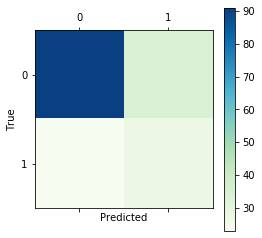

Classfication report:               precision    recall  f1-score   support

           1       0.80      0.73      0.76       125
           2       0.44      0.54      0.49        50

    accuracy                           0.67       175
   macro avg       0.62      0.63      0.62       175
weighted avg       0.70      0.67      0.68       175



In [38]:
# Predict Output

y_pred=classifier.predict(X_test)

dt_score = round(classifier.score(X_train, y_train) * 100, 2)
dt_test = round(classifier.score(X_test, y_test) * 100, 2)

decision_tree_score      = round(rf.score(X_train, y_train) * 100, 2)
decision_tree_score_test = round(rf.score(X_test, y_test) * 100, 2)

print('Decision tree Score: ', decision_tree_score)
print('Decision tree Test Score: ', decision_tree_score_test)
print('Accuracy: ', accuracy_score(y_test,y_pred))

c_m = confusion_matrix(y_test, y_pred)
print ("Confusion matrix\n", c_m,'\n')
ax=plt.matshow(c_m,cmap=plt.cm.GnBu)
print('Confusion matrix plot')
plt.colorbar(ax)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


print('Classfication report:',classification_report(y_test, y_pred)) 
